In [1]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

import pandas as pd


/Users/karthickkumarasamy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:

# Load your data
df = pd.read_csv("synthetic_5g_qos_dataset_10000.csv")

# Encode categorical columns
le_src = LabelEncoder()
le_dst = LabelEncoder()
le_proto = LabelEncoder()
le_qos = LabelEncoder()

df['source_ip_enc'] = le_src.fit_transform(df['source_ip'])
df['destination_ip_enc'] = le_dst.fit_transform(df['destination_ip'])
df['protocol_enc'] = le_proto.fit_transform(df['protocol'])
df['qos_class_enc'] = le_qos.fit_transform(df['qos_class'])


In [3]:

# Select features and target
features = ['source_ip_enc', 'destination_ip_enc', 'protocol_enc', 'packet_size', 'inter_arrival_time_ms', 'jitter_ms']
X = df[features]
y = df['qos_class_enc']

# Scale features (very important for KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [4]:
# Initialize KNN with k=5 (can be tuned)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict
y_pred = knn.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.974
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       693
           1       0.97      0.97      0.97       662
           2       1.00      0.97      0.98       645

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



<IPython.core.display.Javascript object>

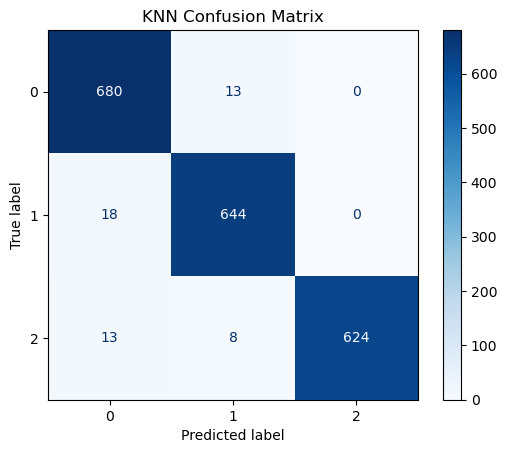

In [5]:
# Confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.show()

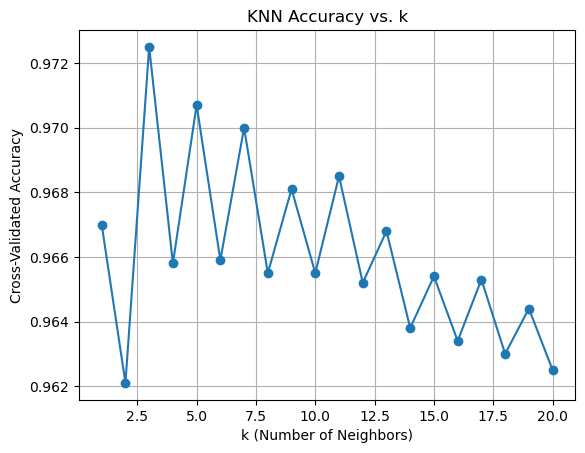

In [6]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

k_values = list(range(1, 21))
cv_scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k), X_scaled, y, cv=5).mean() for k in k_values]

plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Accuracy vs. k')
plt.grid(True)
plt.show()


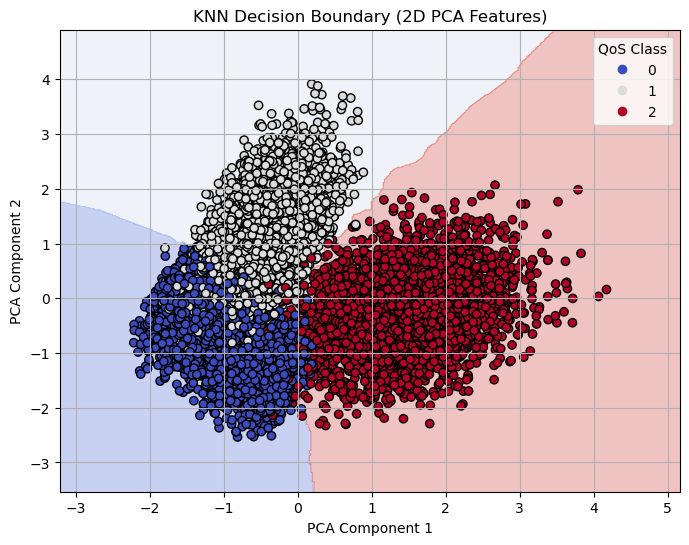

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reduce to 2D with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Plot decision boundary
h = .02
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("KNN Decision Boundary (2D PCA Features)")
plt.legend(*scatter.legend_elements(), title="QoS Class")
plt.grid(True)
plt.show()



📄 Macro Average AUC: 0.9717
📄 Weighted Average AUC: 0.9714


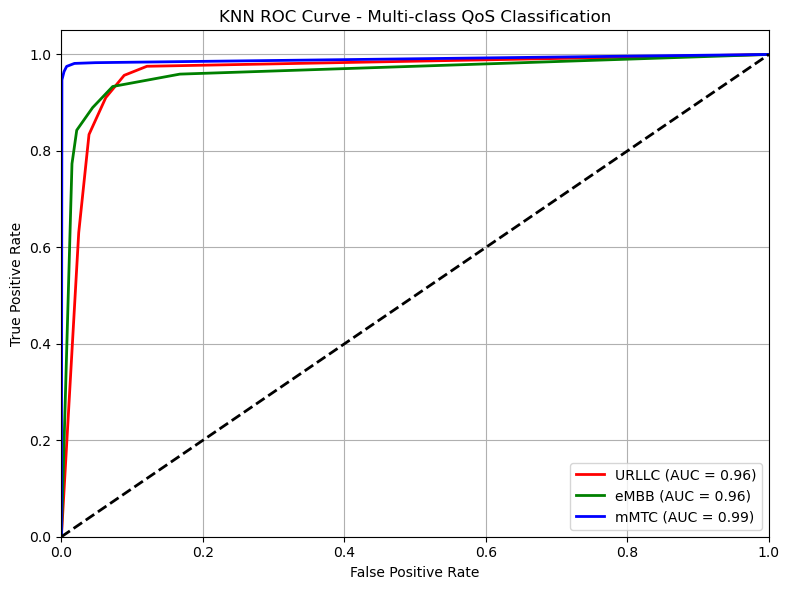

In [8]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Step 1: Get predicted probabilities from KNN
y_score = knn.predict_proba(X_test)

# Step 2: Binarize the test labels
n_classes = len(np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Step 3: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
auc_scores = []

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    auc_scores.append(roc_auc[i])

# Step 4: Print macro and weighted average AUC
macro_auc = np.mean(auc_scores)
weighted_auc = roc_auc_score(y_test_bin, y_score, average='weighted', multi_class='ovr')

print(f"\n📄 Macro Average AUC: {macro_auc:.4f}")
print(f"📄 Weighted Average AUC: {weighted_auc:.4f}")

# Step 5: Plot ROC curves
qos_labels = le_qos.inverse_transform(np.arange(n_classes))
colors = cycle(['red', 'green', 'blue'])

plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{qos_labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN ROC Curve - Multi-class QoS Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
